# Updated 05/09/23
# Visualizes with kinematics (not) marginalized over G and no-G because J0330 doesn't have G-band

# Modified from plot_kinematics_contours_V_VD_bspline_models_margin_gnog_050823.ipynb

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import plot_contours_531
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf
from slacs_mge_jampy import plot_kinematics_mge_contours
from slacs_mge_jampy import get_bin_centers
from slacs_mge_jampy import jampy_details

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC


In [2]:
# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2023-02-28_2'

###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2023-02-28_2/



# Modify the function to be able to use my most recent run.

In [3]:
def load_kinematics_modified (file_dir, obj_name, vorbin_SN_target, binned_or_2d):
    
    V = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_combinedG_V_{binned_or_2d}.txt', delimiter=',')
    VD = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_combinedG_VD_{binned_or_2d}.txt', delimiter=',')
    
    if binned_or_2d == '2d':
        dV = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_combinedG_dV_{binned_or_2d}.txt', delimiter=',')
        dVD = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_combinedG_dVD_{binned_or_2d}.txt', delimiter=',')
        
    else:
        V_covariance = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_combinedG_V_covariance_matrix.txt',
                                 delimiter=',')
        dV = np.sqrt(np.diagonal(V_covariance)) # diagonal is sigma**2
        VD_covariance = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_combinedG_VD_covariance_matrix.txt',
                                 delimiter=',')
        dVD = np.sqrt(np.diagonal(VD_covariance)) # diagonal is sigma**2
    
    return V, dV, VD, dVD

In [4]:
def get_bins (file_dir, obj_name):
    
    scale=0.1457
    
    #######################################
    ## import voronoi binning data
    voronoi_binning_data = fits.getdata(file_dir +'voronoi_binning_' + obj_name + '_data.fits')
    vorbin_pixels = np.genfromtxt(f'{file_dir}voronoi_2d_binning_{obj_name}_output.txt',
                     delimiter='')
    # sort the voronoi bin pixel data by bin
    vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]
    
    ########################################
    # find bin centers
    xbin, ybin = get_bin_centers (vorbin_pixels, len(voronoi_binning_data))
    
     #######################################
    # Changes - 11/30/22
    #######################################

    # convert to arcsec # kcwi!
    xbin_arcsec = xbin * scale
    ybin_arcsec = ybin * scale

    return xbin_arcsec, ybin_arcsec

In [5]:
###################################################################

# define function to do all of the steps together

def plot_kinematics_mge_contours_modified_for_J0330 (data_dir, hst_dir, mosaics_dir, kinematics_dir, tables_dir, obj_name, obj_names_index, 
                                  frac, levels, binning, magsteps, magrange,
                                  align_phot=False, add_rot_phot=False, add_rot_kin=False, skip_kcwi=False, debug=False):
    
    '''
    This modifies the directory settings and things to be able to take the inputs from J0330 with no G-band.
    '''
    
    print('#####################################################################################################################')
    print('#####################################################################################################################')
    print()
    print(f'Beginning final kinematics visualization and plotting for object {obj_name}.')
    print()

    obj_abbr = obj_name[4:9] # e.g. J0029
    
        #------------------------------------------------------------------------------
    # object-specific directories
    
    mos_dir = f'{mosaics_dir}{obj_name}/' 
    kin_dir = f'{kinematics_dir}{obj_name}/'
    
    #################################################################################################################################
    #### MGE STUFF!
    print('################################################################################################')
    print('Starting MGE modeling')
    
    # import image, center, and crop
    #######################################################################################
    # kcwi datacube
    
    print('################################################')
    print('Getting KCWI datacube')

    kcwi_img, kcwi_5arc_img, kcwi_3arc_img, kcwi_header, \
        kcwi_central_pix_x, kcwi_central_pix_y, kcwi_pa = import_center_crop(data_dir, mos_dir, obj_name, obj_names_index, obj_abbr, 
                                                                              data_source='kcwi_datacube', plot=True)

    #######################################################################################
    # hst cutout
    
    print('################################################')
    print('Getting HST cutout')

    hst_full_img, hst_5arc_img, hst_3arc_img, bspl_full_img, bspl_5arc_img, bspl_3arc_img, hst_header, \
        central_pix_x, central_pix_y, exp_time = import_center_crop(data_dir, hst_dir, obj_name, obj_names_index, obj_abbr, 
                                                          data_source='HST', plot=True)


    #######################################################################################
    # take 5 arcsec images
    # TAKE THE FULL bspline IMAGE FOR MGE FITTING. THE CONTOURS ARE NOT RIGHT WHEN I FIT THE 5 ARCSEC IMAGE
    
    img = bspl_full_img # This is the image that will be fit with MGE
    hst_img = hst_5arc_img # These three will be used to plot, e.g. the log image
    bspl_img = bspl_5arc_img
    kcwi_img = kcwi_5arc_img

    #######################################################################################
    # calculate the minimum level for inclusion in the photometry fitting from the background
    # minlevel is half the std of the sky patch, this value is for the sectors_photometry function
    # skylevel (std of sky patch) is for smoothing the log image for plotting next to the contours
    
    print('################################################')
    print('Calculating sky level')

    size=50
    minlevel, noise = calculate_minlevel(img, size, plot=False) 
    skylevel = minlevel*2

    #######################################################################################
    # estimate psfs
    
    print('################################################')
    print('Estimating PSFs')
    print(f'KCWI PSF exists, loading...')
    kcwi_sigmapsf = pd.read_csv(f'{tables_dir}bspline_mge_fits_info.csv', delimiter=',').loc[obj_names_index, 'kcwi_sigmapsf_bspline']
    
    print('################################################')
    print('HST PSF')
    
    # estimate without lower minvalue 
    #if debug==False:
    #    estimate_hst_psf(hst_dir, obj_name, obj_abbr)    
    
    hst_psf_file = glob.glob(f'{mos_dir}{obj_name}_hst_psf.txt')
    if hst_psf_file:
        print('hst psf info exists, loading...')
        hst_sigmapsf, hst_normpsf = np.genfromtxt(f'{mos_dir}{obj_name}_hst_psf.txt', delimiter=',')
    
    else:
        #################################################
        # Check the minlevel by eye
        print('Check this minlevel')
        minlevel = 2*1e-6 # this value is typically much lower than needed

        # find sigmapsf and normpsf of hst image
        hst_sigmapsf, hst_normpsf = estimate_hst_psf(hst_dir, obj_name, obj_abbr, minlevel=minlevel)
        # circular psf is weighted mean
        #print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! normpsf is ', hst_normpsf)
        #print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! sigmapsf is ', hst_sigmapsf)
        hst_sigmapsf_circ = np.average(hst_sigmapsf, weights=hst_normpsf)*hst_scale
        print('mean psf sigma is ', hst_sigmapsf_circ)
        hst_psf_fwhm = 2.355*hst_sigmapsf_circ
        print(f'HST PSF FWHM = {hst_psf_fwhm} arcsec')
        if hst_psf_fwhm < 0.1:
            print('HST PSF should not be that low.')
            # write lines for log
            l1 = '\n######################################'
            l2 = f'\n{obj_name}'
            l3 = f'\nHST PSF FWHM: {hst_psf_fwhm}'
            file = open(f'flag_log.txt', 'a')
            file.writelines([l1, l2, l3])
        
        np.savetxt(f'{mos_dir}{obj_name}_hst_psf.txt', np.array([hst_sigmapsf, hst_normpsf]), delimiter=',')

    #######################################################################################
    # fit the photometry
    
    print()
    print('################################################')
    print('Fitting photometry')

    #################################################
    # Model the central light ellipse
    
    print('################################################')
    print('First fit of central light ellipse')

    plt.clf()
    #plt.clf()
    file_f = glob.glob(f'{mos_dir}{obj_name}_find_galaxy_model.pkl')
    if file_f:
        print('find_galaxy model exists, loading...')
        with open(file_f[0], 'rb') as file:
            f = pickle.load(file)
        eps = f.eps
        theta = f.theta
        cen_y = f.ypeak
        cen_x = f.xpeak
            
    else:
        f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
        eps = f.eps
        theta = f.theta
        cen_y = f.ypeak
        cen_x = f.xpeak
        #plt.contour(img, colors='grey', extent=[-3,3,-3,3], levels=[0.1, 0.2, 0.4, 0.7, 1.0], zorder=1)
        plt.title(f'fract: {frac}, theta: {np.around(theta,2)}')
        plt.pause(1)
        
        # save f as a pickle
        with open(f'{mos_dir}{obj_name}_find_galaxy_model.pkl', 'wb') as file:
            pickle.dump(f, file)

    ################################################
    # Perform galaxy photometry with full image
    
    print('################################################')
    print('Calculating photometry of sectors')

    #plt.clf()
    file_s = glob.glob(f'{mos_dir}{obj_name}_sectors_photometry_model.pkl')
    if file_s:
        print('sectors_photometry model exists, loading...')
        with open(file_s[0], 'rb') as file:
            s = pickle.load(file)
            
    else:
        s = sectors_photometry(img, eps, theta, cen_x, cen_y, minlevel=minlevel, plot=1)
        plt.pause(1)  # Allow plot to appear on the screen
        plt.clf()
        
        with open(f'{mos_dir}{obj_name}_sectors_photometry_model.pkl', 'wb') as file:
            pickle.dump(s, file)

    ################################################
    # Do the first MGE fit
    
    print('################################################')
    print('First MGE fit')

    # select number of gaussians to fit
    ngauss = 12
    # pixel scale
    scale = hst_scale
    # psf - take from the MGE psf model above
    sigmapsf = hst_sigmapsf
    normpsf = hst_normpsf

    # exposure time
    #exp_time = hstF435_header['EXPTIME']

    # fit and plot
    
    file_m = glob.glob(f'{mos_dir}{obj_name}_mge_fit_sectors_regularized_model.pkl')
    if file_m:
        print('mge model exists, loading...')
        with open(file_m[0], 'rb') as file:
            m = pickle.load(file)
            
        print('################################################')
        print('Regularized MGE fit')
            
    else:
        plt.clf()
        m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                            ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                            scale=scale, plot=1, bulge_disk=0, linear=0,
                           quiet=True)
        plt.pause(1)

        # plot the contours on the image
        plot_contours_531 (img, f, m, sigmapsf, normpsf, contour_alpha=0.4, data_source='HST')
        plt.pause(1)

        ######################################################
        # Do the actual MGE fit

        print('################################################')
        print('Regularized MGE fit')

        # fit and plot

        plt.clf()
        m = mge_fit_sectors_regularized(s.radius, s.angle, s.counts, eps,
                            ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                            scale=scale, plot=1, bulge_disk=0, linear=0,
                                       quiet=True)
        plt.pause(1) 
        plt.clf()
        
        # save m as a pickle
        with open(f'{mos_dir}{obj_name}_mge_fit_sectors_regularized_model.pkl', 'wb') as file:
            pickle.dump(m, file)
    
    # update the ellipticity measurement
    # m solution has set of Gaussians, weight by the normalized total counts and average to get the best estimate
    weights = m.sol[0]/np.sum(m.sol[0])
    qs = m.sol[2]
    q = np.sum(weights*qs)
    ellipticity = 1 - q
    print(f'Best fit ellipticity = {ellipticity}')

    # plot the contours on the image
    plot_contours_531 (img, f, m, sigmapsf, normpsf, contour_alpha=0.4, data_source='HST')
    plt.pause(1)
    plt.clf()
    
    
    ########### NEW THING FROM JAM NOTEBOOK###############################
    print('################################################')
    print('Converting to surface density and real units!')
    # bring in dust extinction table
    extinctions = pd.read_csv(f'{data_dir}tables/slacs_Iband_extinctions.csv')
    extinction = extinctions.loc[extinctions.obj_name == obj_name, 'A_I'].values[0]
    # convert sigma (of gaussian components) from pixels to arcsec and surface brightness to surface density
    mge_sigma, surf_density = convert_mge_model_outputs (m, exp_time, extinction, qs, data_source='F435W')
    ####################
    
    #######################################
    # get reff
    print('#################################################')
    print('Calculating half-light isophote and circularized half-light radius')
    reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_density, mge_sigma, qs)
    # slacs reff
    slacs_table = np.genfromtxt(f'{data_dir}tables/slacs_tableA1.txt', delimiter='', dtype='U10')
    slacs_table_name = obj_name[4:]
    slacs_reffs = slacs_table[:,7].astype(float)
    reff_slacs = slacs_reffs[slacs_table[:,0]==slacs_table_name]
    print('effective radius mge: ', reff)
    print('effective radius slacs: ', reff_slacs)
    if reff < 0.5*reff_slacs:
        print('Effective radius should not be that small')
        # write lines for log
        l1 = '\n######################################'
        l2 = f'\n{obj_name}'
        l3 = f'\nEffective radius from MGE: {reff}'
        l4 = f'\nEffective radius from SLACS: {reff_slacs}'
        file = open(f'flag_log.txt', 'a')
        file.writelines([l1, l2, l3, l4])
        
    #######################################################################################
    # bring in kinematics
    
    # This is where the SN targets need to be accounted for.
    
    print('################################################')
    print('Loading kinematics')
    print()
    print('Each target S/N will be calculated totally.')
        
    for vorbin_SN_target in vorbin_SN_targets:
        
        target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
        # create kin_dir if not exists
        #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)
        
        print('################################################')
        print('################################################')
        print()
        print('Working with S/N target ', vorbin_SN_target)
        print()
        print('################################################')
        print('################################################')

        # point to final kinematics directory for the vorbin sn target
        fin_kin_dir = f'{target_dir}{obj_name}_{vorbin_SN_target}_final_kinematics/no_g/'
        
        # load the kinematics data as 2d maps and bin arrays
        V, dV, VD, dVD = load_kinematics_modified (fin_kin_dir,  obj_name, vorbin_SN_target, '2d')
        V_bin, dV_bin, VD_bin, dVD_bin = load_kinematics_modified (fin_kin_dir, obj_name, vorbin_SN_target, 'binned')

        # remove pixels that have VD > 350 and VD < 50, etc?

        ################################################
        # bin velocity maps

        print('################################################')
        print('Get bins')

        xbin_arcsec, ybin_arcsec = get_bins (target_dir, obj_name)

        # Check binning

        # plot with arcsec
        width =  V.shape[0]/2 * kcwi_scale
        extent = [-width,width,-width,width]
        plt.figure(figsize=(8,8))
        plt.imshow(V, origin='lower', extent=extent, cmap='sauron')
        plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')
        plt.pause(1)
        plt.clf()

        ##################################################
        # correct barycenter velocity and PA

        print('################################################')
        print('Correcting barycentre velocity and calculating PA_kin')

        # kinematic PA is measured from the kinematic map's N thru E (ie. "counter clockwise of up", if KCWI aperture position angle was not set to 0, this will not be really north)
        PA_kin_, dPA_kin, velocity_offset = fit_kinematic_pa(xbin_arcsec, ybin_arcsec, V_bin)#, debug=debug)
        # convert to N thru E
        PA_kin = PA_kin_ + kcwi_pa

        plt.pause(1)
        plt.clf()

        # Correct the velocity
        V = V - velocity_offset
        V_bin = V_bin - velocity_offset

        # PA_phot is theta from find_galaxy, measured from negative x-axis
        # convert to N thru E (this will be true north because HST images are oriented that way [I think...])
        PA_phot = 270 - theta

        ##################################################
        # rotate the bins by the kinematics PA and the photometric PA
        # plot the rotation with the "non-symmetrized velocity field"

        #print('################################################')
        print('Checking PA by rotating bins by each PA')

        # kinematics
        xbin_kin, ybin_kin, _ = rotate_bins (PA_kin+180, xbin_arcsec, ybin_arcsec, V_bin, plot=True)
        plt.pause(1)
        plt.clf()

        # phomotometry
        xbin_phot, ybin_phot, _ = rotate_bins (PA_phot+180, xbin_arcsec, ybin_arcsec, V_bin, plot=True)
        plt.pause(1)
        plt.clf()

        # both kinematic and photometric PA should be less than 180
        print(f'KCWI PA : {kcwi_pa}') # PA of KCWI aperture relative to N
        print(f'Kinematic PA: {PA_kin}')
        print(f'Photometric PA: {PA_phot}') # PA from photometry

        #######################################
        # rms velocity
        print('################################################')
        print('Calculating rms velocity')
        Vrms_bin = np.sqrt(V_bin**2 + VD_bin**2)
        dVrms_bin = np.sqrt((dV_bin*V_bin)**2 + (dVD_bin*VD_bin)**2)/Vrms_bin

        #################################################################################################################
        ### make final plots
        ##################################################
        # plot the velocity map without the axis, save figure

        print('################################################')
        print('Plotting and saving velocity map without axis')

        plt.rcParams.update({'font.size': 18})

        ###################################################
        # velocity map without contours
        # first rotate the map by the KCWI PA to position it with y axis up pointing N
        
        # velocity_range
        vel_range = np.nanmax(np.abs(V))
        # get extent of kinematics from pixels
        width =  V.shape[0]/2 * kcwi_scale
        kin_extent = [-width,width,-width,width]

        # velocity_range
        vel_range = np.nanmax(np.abs(V))
        plt.figure(figsize=(8,8))
        plt.imshow(V, origin='lower', extent=kin_extent, cmap='sauron', vmin=-vel_range-5, vmax=vel_range+5)
        plt.axis('off')
        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_V_map_no_axis.png', bbox_inches='tight', pad_inches=0.0)

        ###################################################
        # velocity DISPERSION map without contours
        # first rotate the map by the KCWI PA to position it with y axis up pointing N

        # velocity_range
        vel_max = np.nanmax(VD)
        vel_min = np.nanmin(VD)
        # get extent of kinematics from pixels
        #width =  V.shape[0]/2 * kcwi_scale
        #kin_extent = [-width,width,-width,width]

        plt.figure(figsize=(8,8))
        plt.imshow(VD, origin='lower', extent=kin_extent, cmap='sauron', vmin=vel_min-5, vmax=vel_max+5)
        plt.axis('off')
        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_VD_map_no_axis.png', bbox_inches='tight', pad_inches=0.0)

        ##################################################
        # load the velocity map sans axis, rotate by KCWI PA, then add to a figure with the contours

        print('################################################')
        print('Loading velocity map and rotating, adding to figure')

        #read the image and map
        input_map = Image.open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_V_map_no_axis.png')
        angle = kcwi_pa
        output_map = input_map.rotate(angle)

        plt.figure(figsize=(8,8))
        plt.imshow(output_map, origin='upper', extent=kin_extent, cmap='sauron', vmin=-vel_range-5, vmax=vel_range+5)

        # get image extent and cut to 5 
        n = int(np.around(5/scale))
        img_extent = np.array([-n, n, -n, n])
        mge_print_contours(img, theta, cen_x, cen_y, m.sol, binning=binning, magsteps=magsteps, magrange=magrange,
                           sigmapsf=sigmapsf, normpsf=normpsf, 
                           scale=hst_scale, extent=img_extent)
        plt.axis('off')
        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_V_map_bspline_contours_no_axis.png', bbox_inches='tight', pad_inches=0.0)

        ###################################################
        # do the same with VD
        print('################################################')
        print('Loading velocity map and rotating, adding to figure')

        #read the image and map
        input_map = Image.open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_VD_map_no_axis.png')
        angle = kcwi_pa
        output_map = input_map.rotate(angle)

        plt.figure(figsize=(8,8))
        plt.imshow(output_map, origin='upper', extent=kin_extent, cmap='sauron', vmin=vel_min, vmax=vel_max)

        # get image extent and cut to 5 
        n = int(np.around(5/scale))
        img_extent = np.array([-n, n, -n, n])
        mge_print_contours(img, theta, cen_x, cen_y, m.sol, binning=binning, magsteps=magsteps, magrange=magrange,
                           sigmapsf=sigmapsf, normpsf=normpsf, 
                           scale=hst_scale, extent=img_extent)

        plt.axis('off')
        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_VD_map_bspline_contours_no_axis.png', bbox_inches='tight', pad_inches=0.0)


        ##################################################
        # load the velocity map and hst log image sans axis, rotate by photometric PA, then add to a figure

        print('################################################')
        print('Loading velocity map and hst image and rotating, adding to figures')

        #read the image and map
        input_V_map = Image.open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_V_map_bspline_contours_no_axis.png')
        input_VD_map = Image.open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_VD_map_bspline_contours_no_axis.png')
        input_bspl_image = Image.open(f'{mos_dir}{obj_name}_hst_bspline_log_img_no_axis.png')
        input_hst_image = Image.open(f'{mos_dir}{obj_name}_hst_log_img_no_axis.png')

        ############################################
        #rotate map and image along PA_phot

        print('################################################')
        print('Aligning map and image along photometric PA')

        angle = 270-PA_phot
        if add_rot_phot == True: # try to get the red on the right
            angle=angle-180
        output_V_map = input_V_map.rotate(angle)
        output_VD_map = input_VD_map.rotate(angle)
        output_bspl_image = input_bspl_image.rotate(angle)
        output_hst_image = input_hst_image.rotate(angle)

        arcsec_width = 10#scale*43
        output_pixel_scale = arcsec_width/output_map.size[0]
        arcsec_in_pixels = 1/output_pixel_scale
        ticks_arcsec = np.linspace(-5,5,11)
        ticks = []

        for i in ticks_arcsec:
            ticks.append(output_map.size[0]/2 + arcsec_in_pixels * i)

        ####################################################################################
        # plot V map

        print('################################################')
        print('Plotting V map')
        
        plt.figure(figsize=(8,8))
        V_plot = plt.imshow(V, extent=extent, cmap='sauron', vmin=-vel_range-5, vmax=vel_range+5)
        plt.imshow(output_V_map)
        #plt.gca().set_visible(False)
        cbar = plt.colorbar(V_plot, shrink=0.85)
        cbar.set_label(r'V [km/s]', labelpad=-5)

        plt.xticks(ticks, labels=ticks_arcsec)
        plt.yticks(ticks, labels=ticks_arcsec)

        # plot the major axes
        # difference in position angle
        print('PA_kin ', PA_kin)
        print('PA_phot ', PA_phot)
        delta_PA = int(PA_kin - PA_phot)
        abs_min_delta_PA = np.min(np.abs([delta_PA,180-np.abs(delta_PA)])) # print the angle that is less than 90 degrees
        print('delta_PA ', delta_PA)
        print('delta_PA < 90', abs_min_delta_PA)
        # kinematic
        x = np.linspace(-arcsec_width/2, arcsec_width/2, 1000)
        ykin = -np.tan(np.radians(delta_PA))*x # I think it's negative because the image is "technically" upside down
        y_pix = ykin * arcsec_in_pixels + 434/2
        x_pix = np.linspace(0,434,1000)
        plt.plot(x_pix,y_pix, 
                 #label='Kinematic', 
                 c='k',
                linestyle=':',
                linewidth=1)
        # photometric
        yphot = np.ones(1000)*434/2
        plt.plot(x_pix,yphot, 
                 #label='Photometric', 
                 c='k',
                linestyle=':',
                linewidth=1)
        # line for contours in legend
        ycontour = -np.ones(len(x_pix))
        plt.plot(x_pix, ycontour, label=f'{magsteps} mag', color='k')
        # add the difference in angle and the ellipticity
        delta_PA_symb = r'$\Delta_{PA}$'
        degree_symb = r'$^\circ$'
        ellipt_symb = r'$\epsilon$'
        # add the difference
        plt.annotate(f'{delta_PA_symb} = {abs_min_delta_PA}{degree_symb}±{np.rint(dPA_kin).astype(int)}', (10,424), color='k')
        plt.annotate(f'{ellipt_symb} = {np.around(ellipticity,2)}', (10,404), color='k')
        plt.annotate(f'{obj_name}', (10,25), color='k', fontsize=20)

        plt.ylim(434,0)
        plt.xlim(0,434)
        plt.xlabel('arcsec')
        plt.ylabel('arcsec')
        plt.legend(loc='upper right', frameon=False)

        #plt.legend(loc='upper left',
        #        fontsize=12)

        #plt.axis('off')

        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_bspline_V_map_aligned_phot_axis.png', bbox_inches='tight')
        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_bspline_V_map_aligned_phot_axis.pdf', bbox_inches='tight')
        plt.pause(1)
        plt.clf()
    

        ####################################################################################
        # plot VD map
        
        print('################################################')
        print('Plotting V map')
        
        plt.figure(figsize=(8,8))
        VD_plot = plt.imshow(VD, extent=extent, cmap='sauron', vmin=vel_min, vmax=vel_max)
        plt.imshow(output_VD_map)
        #plt.gca().set_visible(False)
        cbar = plt.colorbar(VD_plot, shrink=0.85)
        cbar.set_label(r'$\sigma$ [km/s]')

        plt.xticks(ticks, labels=ticks_arcsec)
        plt.yticks(ticks, labels=ticks_arcsec)

        # plot the major axes
        # difference in position angle
        #print('PA_kin ', PA_kin)
        #print('PA_phot ', PA_phot)
        delta_PA = int(PA_kin - PA_phot)
        abs_min_delta_PA = np.min(np.abs([delta_PA,180-np.abs(delta_PA)])) # print the angle that is less than 90 degrees
        #print('delta_PA ', delta_PA)
        #print('delta_PA < 90', abs_min_delta_PA)
        # kinematic
        x = np.linspace(-arcsec_width/2, arcsec_width/2, 1000)
        ykin = -np.tan(np.radians(delta_PA))*x # I think it's negative because the image is "technically" upside down
        y_pix = ykin * arcsec_in_pixels + 434/2
        x_pix = np.linspace(0,434,1000)
        plt.plot(x_pix,y_pix, 
                 #label='Kinematic', 
                 c='k',
                linestyle=':',
                linewidth=1)
        # photometric
        yphot = np.ones(1000)*434/2
        plt.plot(x_pix,yphot, 
                 #label='Photometric', 
                 c='k',
                linestyle=':',
                linewidth=1)
        # line for contours in legend
        ycontour = -np.ones(len(x_pix))
        plt.plot(x_pix, ycontour, label=f'{magsteps} mag', color='k')
        # add the difference in angle and the ellipticity
        delta_PA_symb = r'$\Delta_{PA}$'
        degree_symb = r'$^\circ$'
        ellipt_symb = r'$\epsilon$'
        # add the difference
        plt.annotate(f'{delta_PA_symb} = {abs_min_delta_PA}{degree_symb}±{np.rint(dPA_kin).astype(int)}', (10,424), color='k')
        plt.annotate(f'{ellipt_symb} = {np.around(ellipticity,2)}', (10,404), color='k')

        plt.ylim(434,0)
        plt.xlim(0,434)
        plt.xlabel('arcsec')
        plt.ylabel('arcsec')
        plt.legend(loc='upper right', frameon=False)

        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_bspline_VD_map_aligned_phot_axis.png', bbox_inches='tight')
        plt.savefig(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_bspline_VD_map_aligned_phot_axis.pdf', bbox_inches='tight')
        plt.pause(1)
        plt.clf()


        ############################################
        # now rotate image along PA_kin
        #### IF YOU DECIDE YOU NEED THIS, JUST GET IT FROM A PREVIOUS NOTEBOOK

        #############################################
        print('#########################################')
        print('Saving details for jampy use')

        details_for_jampy = jampy_details(surf_density, mge_sigma, qs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)
        # save to pickle
        with open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_details_for_jampy.pkl', 'wb') as f:
            pickle.dump(details_for_jampy, f)
            
        axis_info = np.array([PA_kin, dPA_kin, PA_phot, delta_PA, ellipticity])
        np.savetxt(f'{fin_kin_dir}{obj_name}phot_kin_axis_info.txt', axis_info, delimiter=',')
    
    print()
    print()
    print('################################################################################################################################')
    print(f"Job's finished!")
    


#####################################################################################################################
#####################################################################################################################

Beginning final kinematics visualization and plotting for object SDSSJ0330-0020.

################################################################################################
Starting MGE modeling
################################################
Getting KCWI datacube
Rotate image by  90.0


<Figure size 576x432 with 0 Axes>

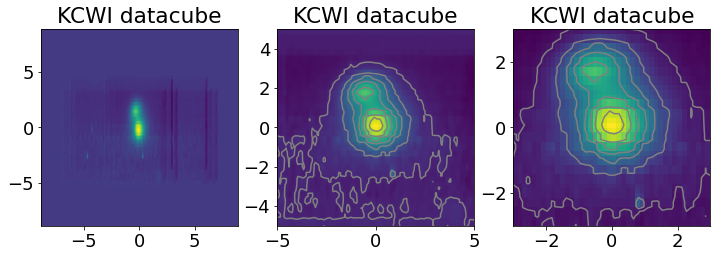

################################################
Getting HST cutout


<Figure size 576x432 with 0 Axes>

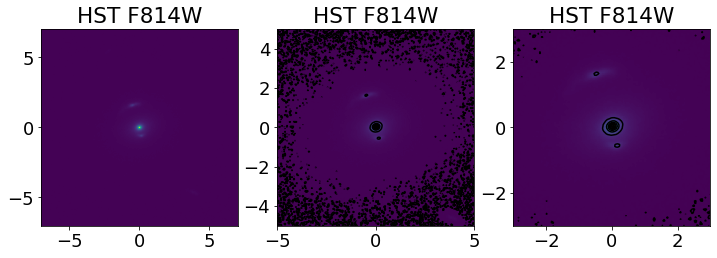

<Figure size 576x432 with 0 Axes>

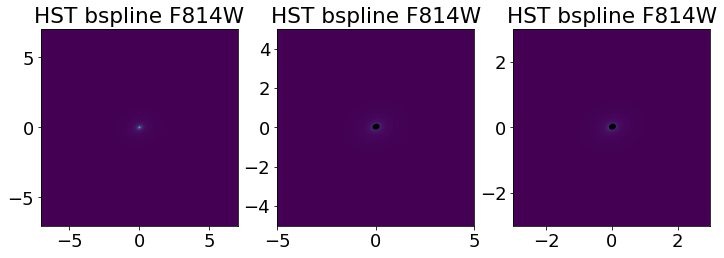

################################################
Calculating sky level
################################################
Estimating PSFs
KCWI PSF exists, loading...
################################################
HST PSF
Check this minlevel


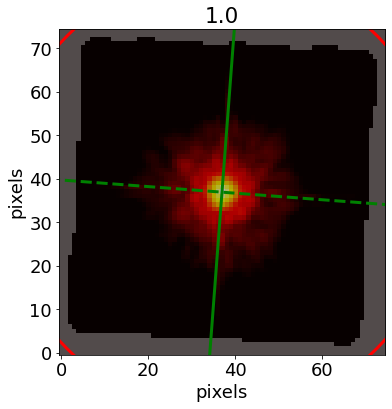

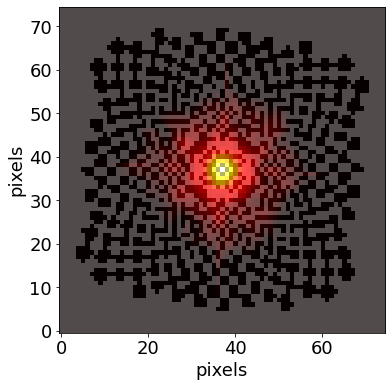

Iteration:1  chi2: 20.70  Nonzero: 7/12
Iteration:11  chi2: 18.69  Nonzero: 5/12
Nonzero Gaussians: 5/12
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration:1  chi2: 18.66  Nonzero: 5/5
Nonzero Gaussians: 5/5
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.51 seconds
  Total Iterations:  13
 Nonzero Gaussians:  5
  Unused Gaussians:  7
 Sectors used in the fit:  19
 Total number of points fitted:  382
 Chi2: 18.66 
 STDEV: 0.2155 
 MEANABSDEV: 0.1638 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  2.524539e-01     0.476211     0.980000
  6.061578e-01      1.27914     0.980000
  8.572188e-02      3.16814     0.980000
  5.582877e-02      8.07383     1.000000
  3.036800e-02      18.4573     1.000000
++++++++++++++++++++++++++++++++++++++++++++


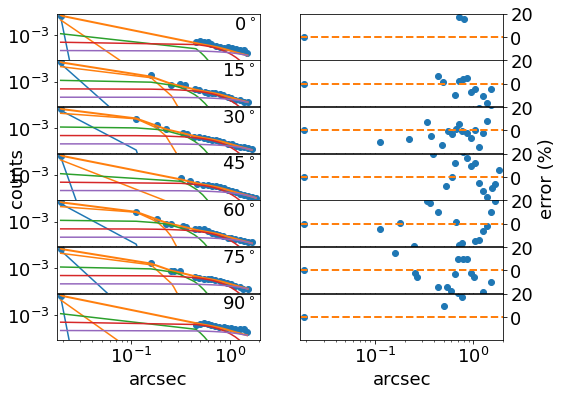

How good is the fit? Should be low (~ 0.02)... 0.16380949392101352
mean psf sigma is  0.10569443846957878
HST PSF FWHM = 0.24891040259585803 arcsec

################################################
Fitting photometry
################################################
First fit of central light ellipse


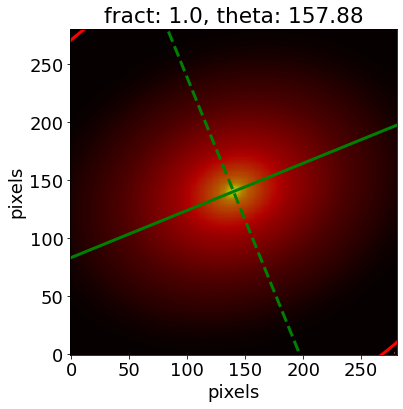

################################################
Calculating photometry of sectors


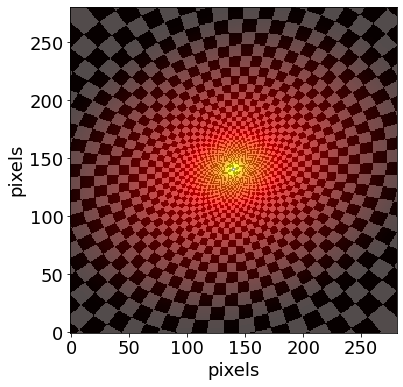

################################################
First MGE fit
Iteration:1  chi2: 2.781  Nonzero: 6/6


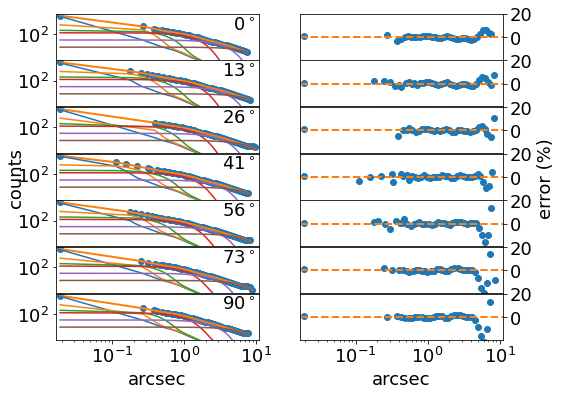

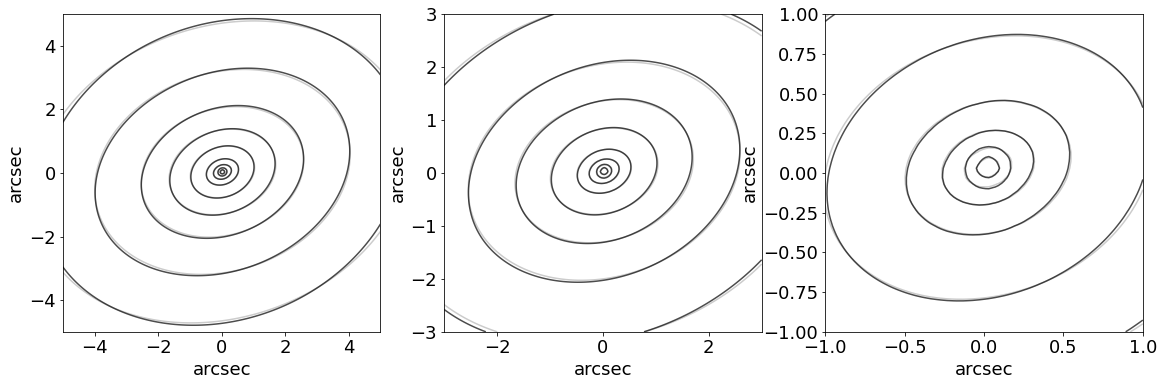

################################################
Regularized MGE fit
Iteration:1  chi2: 2.781  Nonzero: 6/6
(minloop) qbounds=0.0500 1.0000
############################################
Iteration:1  chi2: 2.792  Nonzero: 6/6
(minloop) qbounds=0.1000 1.0000
############################################
Iteration:1  chi2: 2.783  Nonzero: 6/6
(minloop) qbounds=0.1500 1.0000
############################################
Iteration:1  chi2: 2.784  Nonzero: 6/6
(minloop) qbounds=0.2000 1.0000
############################################
Iteration:1  chi2: 2.786  Nonzero: 6/6
(minloop) qbounds=0.2500 1.0000
############################################
Iteration:1  chi2: 2.789  Nonzero: 6/6
(minloop) qbounds=0.3000 1.0000
############################################
Iteration:1  chi2: 2.792  Nonzero: 6/6
(minloop) qbounds=0.3500 1.0000
############################################
Iteration:1  chi2: 2.796  Nonzero: 6/6
(minloop) qbounds=0.4000 1.0000
############################################
Ite

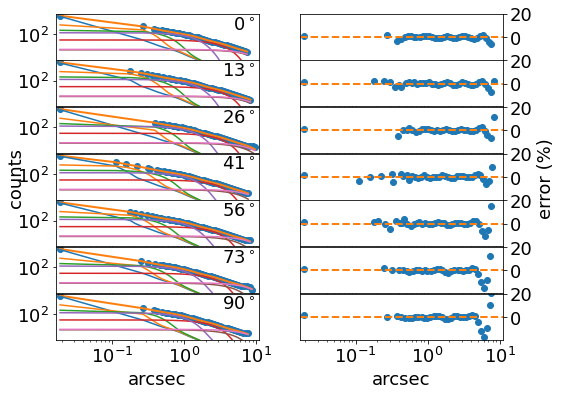

Best fit ellipticity = 0.2302089879557525


<Figure size 576x432 with 0 Axes>

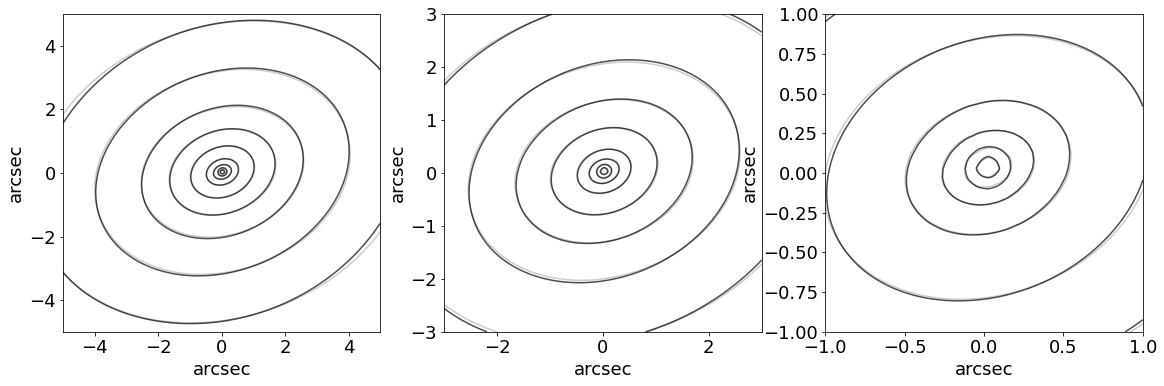

################################################
Converting to surface density and real units!
#################################################
Calculating half-light isophote and circularized half-light radius
effective radius mge:  1.3142155054883597
effective radius slacs:  [1.2]
################################################
Loading kinematics

Each target S/N will be calculated totally.
################################################
################################################

Working with S/N target  10

################################################
################################################


OSError: /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2023-02-28_2/SDSSJ0330-0020/target_sn_10/SDSSJ0330-0020_10_marginalized_gnog_final_kinematics/SDSSJ0330-0020_10_combinedG_V_2d.txt not found.

<Figure size 576x432 with 0 Axes>

In [28]:
# object 2

i=2

obj_name = obj_names[i]

# things I may want to tweak
frac = 1.0
levels = np.linspace(0.2, 0.8, 5)
binning = 1
magrange = 15
magsteps = 1.0

print('This one needs to be done in a different way.')
obj_names_index = i
#plot_kinematics_mge_contours_modified (data_dir, hst_dir, mosaics_dir, kinematics_dir, tables_dir, obj_name, obj_names_index, 
#                                             frac, levels, binning, magsteps, magrange, add_rot_phot=False, add_rot_kin=True)#, debug=True)